In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# CHECK WORKIND DIR PATH
import os
# MODIFY SYSTEM PATH
os.chdir('/Users/igorgarbuz/Dev/catlearn')
os.getcwd()

'/Users/igorgarbuz/Dev/catlearn'

In [318]:
# UNCOMMENT BELOW TO SHOW WARNING
import warnings
# Needed to show warnings in all Jupyter distributions (e.g. VS Code Jupyter implementation)
warnings.simplefilter(action="default")
import random
import numpy as np
import itertools
import collections
import graphistry
from pathlib import Path
from multiprocessing import Pool
from statistics import mean
import networkx as nx
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from catlearn.data.dataset import Dataset
from catlearn.graph_utils import DirectedGraph
from catlearn.data.utils import write_file, read_file

## Graphs statistics
1. Show statistics on nodes edges in a matrix for train, valid, test.  
2. Show % and number of nodes / edges from valid, test not in train.
3. Plot graph total nodes edges, with percentage shared train/valid/test and percentage unique for test/valid.  
4. Compute clique index, diameter, centrality, degree histogram


In [4]:
# Example WN18 dataset
ds_path = '/Users/igorgarbuz/Dev/catlearn/Datasets/wn18rr/text'

In [5]:
# Explore WN18 dataset
ds = Dataset(path=ds_path, ds_name='wn18', node_vec_dim=10); type(ds)

catlearn.data.dataset.Dataset

In [6]:
# Load dataset into RAM
ds_train = list(ds.train)
ds_valid = list(ds.valid)
ds_test = list(ds.test)

In [7]:
print(f'{"Total unique entities in Train+Valid+Test:":50} {len(ds.entity2id)}')
print(f'{"Total unique relations in Train+Valid+Test:":50} {len(ds.relation2id)}')

Total unique entities in Train+Valid+Test:         41105
Total unique relations in Train+Valid+Test:        11


In [8]:
# Entities separatelly per train/valid/test 
entities_train = [v for tpl in ds_train for v in tpl if not isinstance(v, dict)]
entities_valid = [v for tpl in ds_valid for v in tpl if not isinstance(v, dict)]
entities_test = [v for tpl in ds_test for v in tpl if not isinstance(v, dict)]
# Get uniques
entities_train_unique = set(entities_train)
entities_valid_unique = set(entities_valid)
entities_test_unique = set(entities_test)

In [9]:
# Before extracting relations check graph is NOT multirelational
max_relations_per_edge_train = max([len(list(v.keys())) for tpl in ds_train for v in tpl if isinstance(v, dict)])
max_relations_per_edge_valid = max([len(list(v.keys())) for tpl in ds_valid for v in tpl if isinstance(v, dict)])
max_relations_per_edge_test = max([len(list(v.keys())) for tpl in ds_test for v in tpl if isinstance(v, dict)])
multirelational = True
if (max_relations_per_edge_train == 1
    and max_relations_per_edge_valid == 1
    and max_relations_per_edge_test == 1
):
    print(f'Graph is NOT multirelational.')
    multirelational = False
else:
    print('Graph is multirelational.')
    print('Check further which part of dataset has multiple relations.')

Graph is NOT multirelational.


In [10]:
# Relations separatelly per train/valid/test
relations_train = (list(v.keys()) for tpl in ds_train for v in tpl if isinstance(v, dict))
relations_valid = (list(v.keys()) for tpl in ds_valid for v in tpl if isinstance(v, dict))
relations_test = (list(v.keys()) for tpl in ds_test for v in tpl if isinstance(v, dict))
if not multirelational:
    relations_train = [v[0] for v in relations_train]
    relations_valid = [v[0] for v in relations_valid]
    relations_test = [v[0] for v in relations_test]
else:
    relations_train = [v for lst in relations_train for v in lst]
    relations_valid = [v for lst in relations_valid for v in lst]
    relations_test = [v for lst in relations_test for v in lst]
relations_train_unique = set(relations_train)
relations_valid_unique = set(relations_valid)
relations_test_unique = set(relations_test)

In [11]:
# Check unique relations are identical in train, valid, and test


In [12]:
# Uniques relations -- equivalent to graph length
print(f'{"Entities Unique total in Train dataset:":50}{len(entities_train_unique):10}')
print(f'{"Entities Unique total in Valid dataset:":50}{len(entities_valid_unique):10}')
print(f'{"Entities Unique total in Test dataset:":50}{len(entities_test_unique):10}')


Entities Unique total in Train dataset:                40714
Entities Unique total in Valid dataset:                 5174
Entities Unique total in Test dataset:                  5323


In [13]:
print(f'{"Relations total in Train dataset:":50}{len(relations_train):10}')
print(f'{"Relations total in Valid dataset:":50}{len(relations_valid):10}')
print(f'{"Relations total in Test dataset:":50}{ len(relations_test):10}')
# Uniques
print()
assert relations_test_unique == relations_train_unique == relations_valid_unique
print(f'{"Relations Unique total in train dataset:":50}{len(relations_train_unique):10}')

Relations total in Train dataset:                      86835
Relations total in Valid dataset:                       3034
Relations total in Test dataset:                        3134

Relations Unique total in train dataset:                  11


In [14]:
# Average Brancing factor https://en.wikipedia.org/wiki/Branching_factor
# NOTE Compute std and/or histogram
print(f'{"Average Branching factor Train:":40} {len(relations_train)/len(entities_train_unique):<05.3}')
print(f'{"Average Branching factor Valid:":40} {len(relations_valid)/len(entities_valid_unique):<05.3}')
print(f'{"Average Branching factor Test:":40} {len(relations_test)/len(entities_test_unique):<05.3}')

Average Branching factor Train:          2.130
Average Branching factor Valid:          0.586
Average Branching factor Test:           0.589


In [15]:
# Check entities in valid and test not in train set
valid_not_in_train = []
test_not_in_train = []
test_not_in_valid = []
valid_not_in_test = []
def not_in_ds(src: set, ds: set, buffer: list):
    for e in src:
        if not e in ds:
            buffer.append(e)
not_in_ds(src=entities_valid_unique, ds=entities_train_unique, buffer=valid_not_in_train)
not_in_ds(src=entities_test_unique, ds=entities_train_unique, buffer=test_not_in_train)
not_in_ds(src=entities_test_unique, ds=entities_valid_unique, buffer=test_not_in_valid)
not_in_ds(src=entities_valid_unique, ds=entities_test_unique, buffer=valid_not_in_test)

In [16]:
print(f'{"Entities in Valid and not in Train set:":50} {len(valid_not_in_train):5}')
print(f'{"Entities in Test and not in Train set:":50} {len(test_not_in_train):5}')
print(f'{"Entities in test and not in Valid set:":50} {len(test_not_in_valid):5}')
print(f'{"Entities in Valid and not in Test set:":50} {len(valid_not_in_test):5}')
print()
print('In percent:')
print(f'{"Perc. entities in Valid and not in Train set:":50} {len(valid_not_in_train)*100/len(entities_train_unique):5.3} %')
print(f'{"Perc. entities in Test and not in Train set:":50} {len(test_not_in_train)*100/len(entities_train_unique):5.3} %')
print(f'{"Perc. entities in test and not in Valid set:":50} {len(test_not_in_valid)*100/len(entities_test_unique):5.3} %')
print(f'{"Perc. entities in Valid and not in Test set:":50} {len(valid_not_in_test)*100/len(entities_valid_unique):5.3} %')

Entities in Valid and not in Train set:              205
Entities in Test and not in Train set:               210
Entities in test and not in Valid set:              4299
Entities in Valid and not in Test set:              4150

In percent:
Perc. entities in Valid and not in Train set:      0.504 %
Perc. entities in Test and not in Train set:       0.516 %
Perc. entities in test and not in Valid set:        80.8 %
Perc. entities in Valid and not in Test set:        80.2 %


### Most of nodes in validation and test sets are present in training set (>99%)

In [17]:
# Example entities
start = random.randint(0, len(ds.entity2id))
slice_length = 5
list(ds.entity2id.items())[start : start + slice_length]

[('transition.v.02', 9691),
 ('chalcedon.n.01', 9692),
 ('ulna.n.01', 9693),
 ('press.n.07', 9694),
 ('certify.v.04', 9695)]

In [18]:
# Relations to id
ds.relation2id

{'_instance_hypernym': 0,
 '_hypernym': 1,
 '_derivationally_related_form': 2,
 '_synset_domain_topic_of': 3,
 '_similar_to': 4,
 '_member_meronym': 5,
 '_has_part': 6,
 '_member_of_domain_usage': 7,
 '_verb_group': 8,
 '_also_see': 9,
 '_member_of_domain_region': 10}

In [19]:
graph_train = DirectedGraph(ds_train)
graph_valid = DirectedGraph(ds_valid)
graph_test = DirectedGraph(ds_test)

In [20]:
print(f'{"Graph length (N Nodes in) Train:":40}{len(graph_train)}')
print(f'{"Graph length (N Nodes in) Valid:":40}{len(graph_valid)}')
print(f'{"Graph length (N Nodes in) Test:":40}{len(graph_test)}')
print()
print(f'{"Edges in Train:":40}{len(graph_train.edges)}')
print(f'{"Edges in Valid:":40}{len(graph_valid.edges)}')
print(f'{"Edges in Test:":40}{len(graph_test.edges)}')

Graph length (N Nodes in) Train:        40714
Graph length (N Nodes in) Valid:        5174
Graph length (N Nodes in) Test:         5323

Edges in Train:                         86726
Edges in Valid:                         3034
Edges in Test:                          3134


### As expected, graph length is equal to number of unique nodes, computed earlier
### Number of edges is equal to number of triplets in the original dataset. It confirms there are not duplicate edges in the dataset.

In [21]:
# Shorter way to get graph statistics.
# In/Out degre is equivalent to branching factor computed earlier -- average number of edges per node
print(nx.info(graph_train))
# print(nx.info(graph_valid))
# print(nx.info(graph_test))

Name: 
Type: DirectedGraph
Number of nodes: 40714
Number of edges: 86726
Average in degree:   2.1301
Average out degree:   2.1301


## Let's plot degree distribution per node
In addition, check how many nodes in train are connected to the same nodes in valid and test (basically check edges cross-talk).
Do cross-talk w/o labels

In [428]:
vertex_degrees_train = sorted([len(graph_train[node]) for node in graph_train], reverse=True)
vertex_degrees_valid = sorted([len(graph_valid[node]) for node in graph_valid], reverse=True)
vertex_degrees_test = sorted([len(graph_test[node]) for node in graph_test], reverse=True)

/Users/igorgarbuz/Dev/catlearn/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


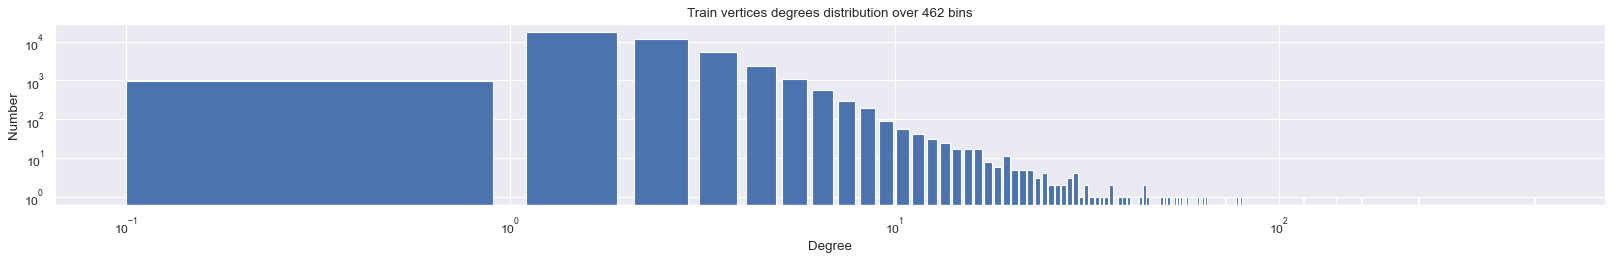

In [371]:
slice_first = 0
slice_last = -1
bins=max(vertex_degrees_train[slice_first:slice_last])
plt.figure(num=None, figsize=(25, 3), dpi=80, facecolor='w', edgecolor='k')
plt.hist(vertex_degrees_train[slice_first:slice_last], bins=bins, rwidth=0.8)
plt.title(f'Train vertices degrees distribution over {bins} bins')
plt.xlabel('Degree')
plt.ylabel('Number')
plt.yscale('log')
plt.xscale('log')
plt.show()

It can be seen that histogram does not give a good overview, especially for all range of values.  
We have to either slice the list to cut off first ~10 largest, or to try to plot in log space.  
Current plot is in log in both, x and y.  Try to comment out x or y log to observe differences in real scales

Even after tuning the log space, it doesn't give the granularity necessary to understand the data.  
Alternative would be to count the unique values and plot the distribution without intermediate values that are absent.  
To remind, histogram is a distribution over a continuous range. A simple 'trick' to compute it over discrete bins would be
to convert list of ints to list of strs.

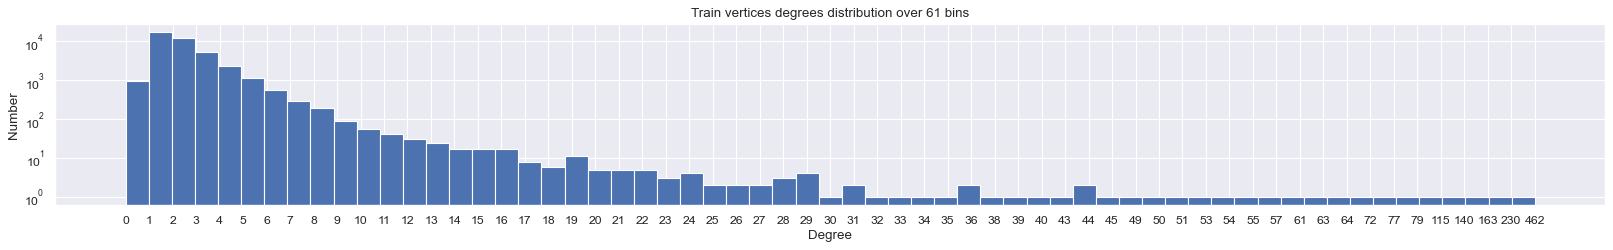

In [423]:
vertex_degrees_train_str = [str(v) for v in vertex_degrees_train][::-1]
bins=len(set(vertex_degrees_train_str))
plt.figure(num=None, figsize=(25, 3), dpi=80, facecolor='w', edgecolor='k')
plt.hist(x=vertex_degrees_train_str, bins=bins, align='mid')
plt.title(f'Train vertices degrees distribution over {bins} bins')
plt.xlabel('Degree')
plt.ylabel('Number')
plt.yscale('log')
plt.show()

Curiously, in training set there are super connencted nodes with 400+ and 200+ connections

In [494]:
super_connected_nodes = [node for node in graph_train if len(graph_train[node]) > 50]
print(f'Super connected nodes:')
for n in super_connected_nodes:
    print(ds.id2entity[n])
# graph_train

Super connected nodes:
france.n.01
africa.n.01
germany.n.01
colloquialism.n.01
united_kingdom.n.01
compositae.n.01
plural.n.01
trade_name.n.01
papilionoideae.n.01
perciformes.n.01
china.n.01
orchidaceae.n.01
cruciferae.n.01
united_states.n.01
slang.n.02
gramineae.n.01


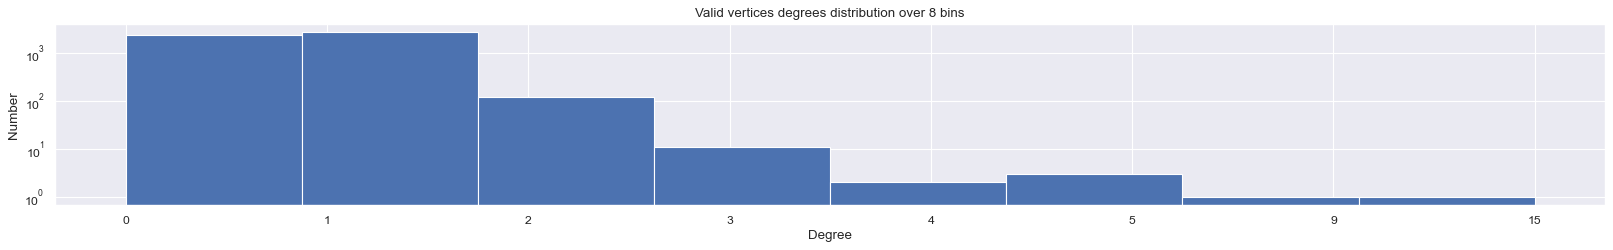

In [429]:
vertex_degrees_valid_str = [str(v) for v in vertex_degrees_valid][::-1]
bins=len(set(vertex_degrees_valid_str))
plt.figure(num=None, figsize=(25, 3), dpi=80, facecolor='w', edgecolor='k')
plt.hist(x=vertex_degrees_valid_str, bins=bins, align='mid')
plt.title(f'Valid vertices degrees distribution over {bins} bins')
plt.xlabel('Degree')
plt.ylabel('Number')
plt.yscale('log')
plt.show()

/Users/igorgarbuz/Dev/catlearn/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


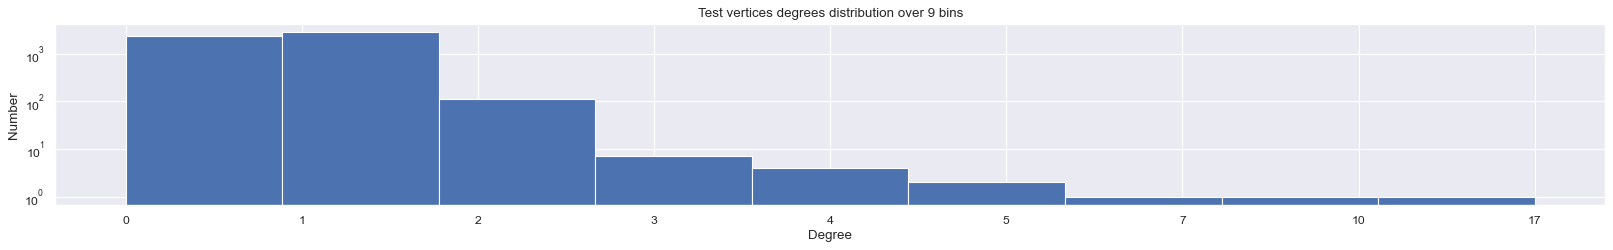

In [432]:
vertex_degrees_test_str = [str(v) for v in vertex_degrees_test][::-1]
bins=len(set(vertex_degrees_test_str))
plt.figure(num=None, figsize=(25, 3), dpi=80, facecolor='w', edgecolor='k')
plt.hist(x=vertex_degrees_test_str, bins=bins, align='mid')
plt.title(f'Test vertices degrees distribution over {bins} bins')
plt.xlabel('Degree')
plt.ylabel('Number')
plt.yscale('log')
plt.show()

Finally, let's represent the graph above as a table.

In [439]:
def unique_ints_count(ints_l: list) -> dict:
    btcnt = np.bincount(np.array(ints_l))
    ii = np.nonzero(btcnt)[0]
    return dict(zip(ii, btcnt[ii]))

In [453]:
# Train set 
uniques_degrees_count_train = unique_ints_count(vertex_degrees_train)
uniques_degrees_count_valid = unique_ints_count(vertex_degrees_valid)
uniques_degrees_count_test = unique_ints_count(vertex_degrees_test)

In [479]:
# NOTE: Uncoment to print out degree count
# uniques_degrees_count_train
# uniques_degrees_count_valid
# uniques_degrees_count_test

In [454]:
# Check that sum of all connections (degrees) count is equal to graph's length
assert len(graph_train) == sum(uniques_degrees_count_train.values())

In [455]:
prc_nodes_no_connection_train = uniques_degrees_count_train[0] * 100 / len(graph_train)
prc_nodes_no_connection_valid = uniques_degrees_count_valid[0] * 100 / len(graph_valid)
prc_nodes_no_connection_test = uniques_degrees_count_test[0] * 100 / len(graph_test)

In [464]:
prc_nodes_one_connection_train = uniques_degrees_count_train[1] * 100 / len(graph_train)
prc_nodes_one_connection_valid = uniques_degrees_count_valid[1] * 100 / len(graph_valid)
prc_nodes_one_connection_test = uniques_degrees_count_test[1] * 100 / len(graph_test)

In [468]:
prc_nodes_two_connections_train = uniques_degrees_count_train[2] * 100 / len(graph_train)
prc_nodes_two_connections_valid = uniques_degrees_count_valid[2] * 100 / len(graph_valid)
prc_nodes_two_connections_test = uniques_degrees_count_test[2] * 100 / len(graph_test)

In [471]:
prc_nodes_more_than_two_connections_train = 100 - prc_nodes_no_connection_train - prc_nodes_one_connection_train - prc_nodes_two_connections_train
prc_nodes_more_than_two_connections_valid =  100 - prc_nodes_no_connection_valid - prc_nodes_one_connection_valid - prc_nodes_two_connections_valid
prc_nodes_more_than_two_connections_test =  100 - prc_nodes_no_connection_test - prc_nodes_one_connection_test - prc_nodes_two_connections_test

In [463]:
first_col_width = 42
print(f'{"Prc of nodes without connection Train:":{first_col_width}} {prc_nodes_no_connection_train:.3} %')
print(f'{"Prc of nodes without connection Valid:":{first_col_width}} {prc_nodes_no_connection_valid:.3} %')
print(f'{"Prc of nodes without connection Test:":{first_col_width}} {prc_nodes_no_connection_test:.3} %')

Prc of nodes without connection Train:     2.36 %
Prc of nodes without connection Valid:     44.9 %
Prc of nodes without connection Test:      44.4 %


It can be concluded that Test and Validation sets are very sparse, with almost half of all vertexes been not connected.  
On the other hand, train dataset is vell connected, with ~70% of all nodes having 1 or 2 Out connections.

In [466]:
first_col_width = 42
print(f'{"Prc of nodes one connection Train:":{first_col_width}} {prc_nodes_one_connection_train:.3} %')
print(f'{"Prc of nodes one connection Valid:":{first_col_width}} {prc_nodes_one_connection_valid:.3} %')
print(f'{"Prc of nodes one connection Test:":{first_col_width}} {prc_nodes_one_connection_test:.3} %')

Prc of nodes one connection Train:         42.9 %
Prc of nodes one connection Valid:         52.5 %
Prc of nodes one connection Test:          53.2 %


In [469]:
first_col_width = 42
print(f'{"Prc of nodes two connections Train:":{first_col_width}} {prc_nodes_two_connections_train:.3} %')
print(f'{"Prc of nodes two connections Valid:":{first_col_width}} {prc_nodes_two_connections_valid:.3} %')
print(f'{"Prc of nodes two connections Test:":{first_col_width}} {prc_nodes_two_connections_test:.3} %')

Prc of nodes two connections Train:        29.4 %
Prc of nodes two connections Valid:        2.32 %
Prc of nodes two connections Test:         2.09 %


In [472]:
first_col_width = 42
print(f'{"Prc of nodes more than two connections Train:":{first_col_width}} {prc_nodes_more_than_two_connections_train:.3} %')
print(f'{"Prc of nodes more than two connections Test:":{first_col_width}} {prc_nodes_more_than_two_connections_valid:.3} %')
print(f'{"Prc of nodes more than two connections Valid:":{first_col_width}} {prc_nodes_more_than_two_connections_test:.3} %')

Prc of nodes more than two connections Train: 25.4 %
Prc of nodes more than two connections Test: 0.348 %
Prc of nodes more than two connections Valid: 0.301 %


/Users/igorgarbuz/Dev/catlearn/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


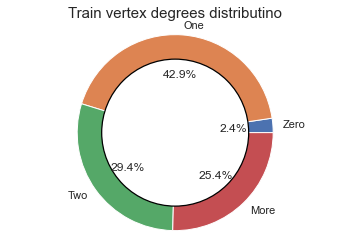

In [487]:
labels = ['Zero', 'One', 'Two', 'More']
sizes = [prc_nodes_no_connection_train, prc_nodes_one_connection_train, prc_nodes_two_connections_train, prc_nodes_more_than_two_connections_train]
explode=(0,0,0,0)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False)
central_circle = plt.Circle((0,0), 0.75, color='black', fc='white', linewidth=1.25)
fig=plt.gcf()
fig.gca().add_artist(central_circle)
plt.axis('equal')
plt.title(f'Train vertex degrees distributino', fontsize=15)
plt.show()

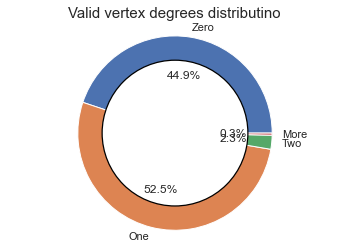

In [488]:
labels = ['Zero', 'One', 'Two', 'More']
sizes = [prc_nodes_no_connection_valid, prc_nodes_one_connection_valid, prc_nodes_two_connections_valid, prc_nodes_more_than_two_connections_valid]
explode=(0,0,0,0)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False)
central_circle = plt.Circle((0,0), 0.75, color='black', fc='white', linewidth=1.25)
fig=plt.gcf()
fig.gca().add_artist(central_circle)
plt.axis('equal')
plt.title(f'Valid vertex degrees distributino', fontsize=15)
plt.show()

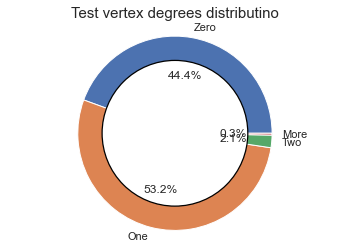

In [489]:
labels = ['Zero', 'One', 'Two', 'More']
sizes = [prc_nodes_no_connection_test, prc_nodes_one_connection_test, prc_nodes_two_connections_test, prc_nodes_more_than_two_connections_test]
explode=(0,0,0,0)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False)
central_circle = plt.Circle((0,0), 0.75, color='black', fc='white', linewidth=1.25)
fig=plt.gcf()
fig.gca().add_artist(central_circle)
plt.axis('equal')
plt.title(f'Test vertex degrees distributino', fontsize=15)
plt.show()

In [30]:
# Equivalent to nx.betweenness_centrality() with multithreading
def chunks(l, n):
    """Divide a list of nodes `l` in `n` chunks"""
    l_c = iter(l)
    while 1:
        x = tuple(itertools.islice(l_c, n))
        if not x:
            return
        yield x


def betweenness_centrality_parallel(G, processes=os.cpu_count()):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), int(G.order() / node_divisor)))
    num_chunks = len(node_chunks)
    bt_sc = p.starmap(
        nx.betweenness_centrality_subset,
        zip(
            [G] * num_chunks,
            node_chunks,
            [list(G)] * num_chunks,
            [True] * num_chunks,
            [None] * num_chunks,
        ),
    )
    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

### If betweenness alraedy computed load them

In [495]:
stats_path = Path(os.getcwd())/'Datasets'/'wn18rr'/'stats'
if not os.path.isdir(stats_path):
    os.mkdir(stats_path)
btwnss_files = [
    stats_path/'betweenness_train.txt',
    stats_path/'betweenness_valid.txt',
    stats_path/'betweenness_test.txt'
]
# Read files if present in the directory
bt_files = [None] * 3
bt_train, bt_valid, bt_test = None, None, None
for idx, file in enumerate(btwnss_files):
    if os.path.isfile(file):
        bt_files[idx] = (line.split('\t') for line in read_file(file))
        bt_files[idx] = [(name, float(value)) for name, value in bt_files[idx]]
bt_train, bt_valid, bt_test = bt_files
bt_train_text, bt_valid_text, bt_test_text = bt_train, bt_valid, bt_test

In [496]:
%%time
# Compute betweenness centrality -- number of shortest paths through each node: https://en.wikipedia.org/wiki/Betweenness_centrality
# NOTE for graph_train time >60 min. Uncoment if dispose enough time / resources
if not bt_train:
    %time bt_train = betweenness_centrality_parallel(graph_train)
    bt_train_text = ((ds.id2entity[k], v) for k, v in bt_train.items())
    bt_train_text = sorted(bt_train_text, key=lambda tpl: tpl[1], reverse=True)
if not bt_valid:
    %time bt_valid = betweenness_centrality_parallel(graph_valid)
    bt_valid_text = ((ds.id2entity[k], v) for k, v in bt_valid.items())
    bt_valid_text = sorted(bt_valid_text, key=lambda tpl: tpl[1], reverse=True)
if not bt_test:
    %time bt_test = betweenness_centrality_parallel(graph_test)
    bt_test_text = ((ds.id2entity[k], v) for k, v in bt_test.items())
    bt_test_text = sorted(bt_test_text, key=lambda tpl: tpl[1], reverse=True)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


## Save betweennees calculation into file

In [35]:
# Define path to store wn18 betweenness calculations
stats_path = Path(os.getcwd())/'Datasets'/'wn18rr'/'stats'
if not os.path.isdir(stats_path):
    os.mkdir(stats_path)
write_file(path=btwnss_files[0], to_file=dict(bt_train_text))
write_file(path=btwnss_files[1], to_file=dict(bt_valid_text))
write_file(path=btwnss_files[2], to_file=dict(bt_test_text))

/Users/igorgarbuz/Dev/catlearn/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/igorgarbuz/Dev/catlearn/catlearn/data/utils.py:38: UserWarning: File $/Users/igorgarbuz/Dev/catlearn/Datasets/wn18rr/stats/betweenness_train.txt already exists. Set force=True to overwrite. Exiting...
  warnings.warn(str_color('W', warning_str), UserWarning)
/Users/igorgarbuz/Dev/catlearn/catlearn/data/utils.py:38: UserWarning: File $/Users/igorgarbuz/Dev/catlearn/Datasets/wn18rr/stats/betweenness_valid.txt already exists. Set force=True to overwrite. Exiting...
  warnings.warn(str_color('W', warning_str), UserWarning)
/Users/igorgarbuz/Dev/catlearn/catlearn/data/utils.py:38: UserWarning: File $/Users/igorga

## Explore most central nodes

In [497]:
print(f'Most central in Train set:\n')
n_most_central = 40
for k, v in bt_train_text[:n_most_central]:
    print(f'{k} : {v:.3}')

Most central in Train set:

person.n.01 : 0.0565
put.v.01 : 0.029
human_body.n.01 : 0.0282
body.n.01 : 0.0281
genus.n.02 : 0.0198
collection.n.01 : 0.0192
travel.v.01 : 0.0187
biology.n.01 : 0.0184
roll_up.v.02 : 0.0166
plant.n.02 : 0.0162
change.v.01 : 0.0153
act.n.02 : 0.0152
plant.v.01 : 0.0146
make.v.03 : 0.0141
scientist.n.01 : 0.0135
classify.v.01 : 0.0124
accumulate.v.02 : 0.0123
arthropod.n.01 : 0.0119
arthropodal.a.01 : 0.0117
arthropoda.n.01 : 0.0117
biologist.n.01 : 0.0115
causal_agent.n.01 : 0.0114
accumulation.n.03 : 0.011
act.v.01 : 0.0105
vascular_plant.n.01 : 0.00997
insecta.n.01 : 0.00992
whole.n.02 : 0.00991
crustacean.n.01 : 0.00968
aggregate.n.03 : 0.00965
plankton.n.01 : 0.00948
copepod.n.01 : 0.00941
trip.v.04 : 0.00876
organism.n.01 : 0.00862
move.v.02 : 0.0086
devising.n.01 : 0.00781
car.n.01 : 0.00778
induce.v.02 : 0.00768
biological.a.01 : 0.00767
biota.n.01 : 0.00765
machine.n.01 : 0.00763


In [498]:
print(f'Most central in Valid set:\n')
n_most_central = 20
for k, v in bt_valid_text[:n_most_central]:
    print(f'{k} : {v:.2}')

Most central in Valid set:

herb.n.01 : 1e-06
vascular_plant.n.01 : 5.6e-07
law.n.01 : 4.5e-07
chemistry.n.01 : 2.6e-07
transgress.v.01 : 2.2e-07
decorate.v.01 : 1.5e-07
fortification.n.02 : 1.5e-07
tree.n.01 : 1.5e-07
legal_document.n.01 : 1.5e-07
offensive.a.05 : 1.5e-07
opinion.n.01 : 1.5e-07
create_by_mental_act.v.01 : 1.5e-07
art.n.03 : 1.1e-07
turn_back.v.05 : 1.1e-07
affirm.v.02 : 1.1e-07
think.v.01 : 1.1e-07
car.n.01 : 1.1e-07
viola.n.01 : 1.1e-07
shaking.n.02 : 1.1e-07
strengthen.v.01 : 1.1e-07


In [499]:
print(f'Most central in Test set:\n')
n_most_central = 20
for k, v in bt_test_text[:n_most_central]:
    print(f'{k} : {v:.2}')

Most central in Test set:

city.n.01 : 8.5e-07
military.n.01 : 3.9e-07
travel.v.01 : 3.2e-07
attach.v.01 : 1.8e-07
hit.v.03 : 1.8e-07
investigation.n.02 : 1.4e-07
categorization.n.03 : 1.4e-07
insert.v.01 : 1.4e-07
representation.n.02 : 1.4e-07
clothing.n.01 : 1.4e-07
program.n.07 : 1.1e-07
investigate.v.02 : 1.1e-07
river.n.01 : 1.1e-07
surprise.n.02 : 1.1e-07
cannulate.v.01 : 1.1e-07
distinguish.v.01 : 1.1e-07
tabulation.n.02 : 1.1e-07
crime.n.01 : 7.1e-08
arrange.v.01 : 7.1e-08
placement.n.01 : 7.1e-08


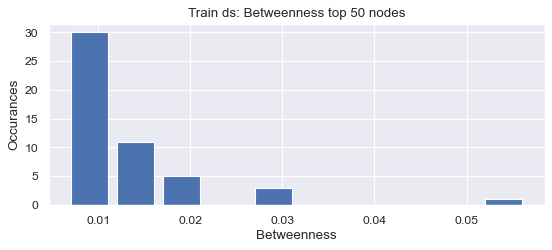

In [500]:
top_n = 50
bins=10
plt.figure(num=None, figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.hist(dict(bt_train_text[:top_n]).values(), bins=bins, rwidth=0.8)
plt.title(f'Train ds: Betweenness top {top_n} nodes')
plt.xlabel('Betweenness')
plt.ylabel('Occurances')
plt.show()

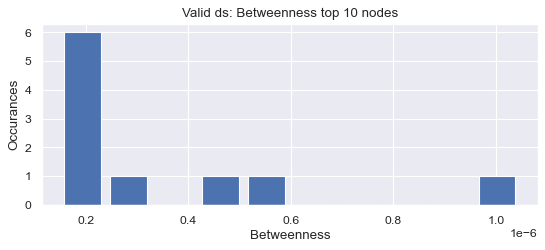

In [501]:
top_n = 10
bins=10
plt.figure(num=None, figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.hist(dict(bt_valid_text[:top_n]).values(), bins=10, rwidth=0.8)
plt.title(f'Valid ds: Betweenness top {top_n} nodes')
plt.xlabel('Betweenness')
plt.ylabel('Occurances')
plt.show()

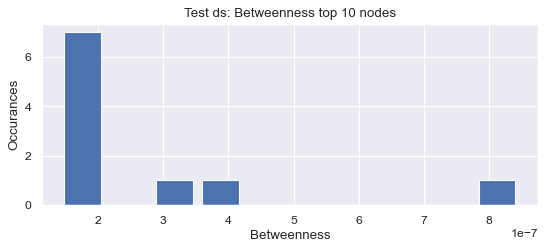

In [502]:
top_n = 10
bins=10
plt.figure(num=None, figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.hist(dict(bt_test_text[:top_n]).values(), bins=bins, rwidth=0.8)
plt.title(f'Test ds: Betweenness top {top_n} nodes')
plt.xlabel('Betweenness')
plt.ylabel('Occurances')
plt.show()

# Compute Diameter
Diameter can only be computed on connected graph
as non strongly connected graph (at least one node have no edge)
by consent have an infinit distance, thus infinit diameter.
Proposed strategy: divide the graph on strongly-connected subgraphs.
Compute the diameter for each subgraph. Consider maximal diameter as 
one for the complete graph.
Explanation: nodes without edges carry no symantic informatino except ebsence of connection.
Max diameter and histogram is an interesting information because it shows order of graph connectiveness.

Diameter can be computed for directed and unidirected graphs.
It is interesting to re-consider input directional graph as unidirectional. 
Explanation: Even thougth x2 symetrical/asymetrical oposite connections may exist (a<=>b),
(the case for WN18 dataset), by agreement in classical graph theory for a->b<-c: `a` is Not connected to `c`.
Hovewer, in knowledge graphs and reasoning, a and c can be considered as connected because they have a common ancestor.
E.g. BMW<-hyponym-Vehicle-Hyponym->Truck. Truck and BMW are connected by e.g <-Related-> or <-similar_to-> relation.
Thus, any directional knowledge- / reasoning graph can be converted to unidirectional to compute diameter, shortest path, etc.

In [503]:
%%time
# nx.diameter(graph_test) won't work because all graph must be connected
# weakly connected components return a directed graph of minimal length 2
# strongly connected components returns a directed graph of minimal length 1 (single node is considered a graph)
sub_graphs_weakly_train = sorted([graph_train.subgraph(nodes) for nodes in nx.weakly_connected_components(graph_train)], key=lambda x: len(x), reverse=True)
sub_graphs_weakly_valid = sorted([graph_valid.subgraph(nodes) for nodes in nx.weakly_connected_components(graph_valid)], key=lambda x: len(x), reverse=True)
sub_graphs_weakly_test = sorted([graph_test.subgraph(nodes) for nodes in nx.weakly_connected_components(graph_test)], key=lambda x: len(x), reverse=True)
sub_graphs_strongly_train = sorted([graph_train.subgraph(nodes) for nodes in nx.strongly_connected_components(graph_train)], key=lambda x: len(x), reverse=True)
sub_graphs_strongly_valid = sorted([graph_valid.subgraph(nodes) for nodes in nx.strongly_connected_components(graph_valid)], key=lambda x: len(x), reverse=True)
sub_graphs_strongly_test = sorted([graph_test.subgraph(nodes) for nodes in nx.strongly_connected_components(graph_test)], key=lambda x: len(x), reverse=True)

CPU times: user 1.98 s, sys: 89.9 ms, total: 2.07 s
Wall time: 2.11 s


In [504]:
# NOTE: Sorting of lengths here is not necessary, as graphs have already been sorted by length. It's kept for verbosity of keeping lists in decreasing order 
sub_graphs_weakly_train_lengths = sorted([sub.number_of_nodes() for sub in sub_graphs_weakly_train], reverse=True)
sub_graphs_weakly_valid_lengths = sorted([sub.number_of_nodes() for sub in sub_graphs_weakly_valid], reverse=True)
sub_graphs_weakly_test_lengths = sorted([sub.number_of_nodes() for sub in sub_graphs_weakly_test], reverse=True)
sub_graphs_strongly_train_lengths = sorted([sub.number_of_nodes() for sub in sub_graphs_strongly_train], reverse=True)
sub_graphs_strongly_valid_lengths = sorted([sub.number_of_nodes() for sub in sub_graphs_strongly_valid], reverse=True)
sub_graphs_strongly_test_lengths = sorted([sub.number_of_nodes() for sub in sub_graphs_strongly_test], reverse=True)

In [505]:
# Weakly connected subgraph tend to have bigger diameter, but there is much smaller quantity of them
# The oposite is observed for strongly connected subgraphs
print(f'{"Number of sub-graphs Weakly Train: ":40}{len(sub_graphs_weakly_train):>5}')
print(f'{"Number of sub-graphs Weakly Valid: ":40}{len(sub_graphs_weakly_valid):>5}')
print(f'{"Number of sub-graphs Weakly Test: ":40}{len(sub_graphs_weakly_test):>5}')
print()
print(f'{"Number of sub-graphs Strongly Train: ":40}{len(sub_graphs_strongly_train):>5}')
print(f'{"Number of sub-graphs Strongly Valid: ":40}{len(sub_graphs_strongly_valid):>5}')
print(f'{"Number of sub-graphs Strongly Test: ":40}{len(sub_graphs_strongly_test):>5}')

Number of sub-graphs Weakly Train:         51
Number of sub-graphs Weakly Valid:       2161
Number of sub-graphs Weakly Test:        2203

Number of sub-graphs Strongly Train:    23511
Number of sub-graphs Strongly Valid:     5155
Number of sub-graphs Strongly Test:      5308


Comparing to total graph lengths below.  

|Name|Value|
|:---|---:|
|Entities Unique total in Train dataset:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;| 40714|  
|Entities Unique total in Valid dataset:|  5174|
|Entities Unique total in Test dataset:|   5323|  

Train graph is weakly connected to large  

In [525]:
first_col_with = 60
print(f'{"Average length of sub-graphs Weakly Train: ":{first_col_with}}{mean(sub_graphs_weakly_train_lengths[1:]):>7.3}')
print(f'{"Max length of sub-graphs Weakly Train: ":{first_col_with}}{max(sub_graphs_weakly_train_lengths):>7}')
print(f'{"Average length of sub-graphs Weakly Train No 1st: ":{first_col_with}}{mean(sub_graphs_weakly_train_lengths):>7.5}')
print(f'{"Average length of sub-graphs Weakly Valid: ":{first_col_with}}{mean(sub_graphs_weakly_valid_lengths):>7.3}')
print(f'{"Max length of sub-graphs Weakly Valid: ":{first_col_with}}{max(sub_graphs_weakly_valid_lengths):>7}')
print(f'{"Average length of sub-graphs Weakly Test: ":{first_col_with}}{mean(sub_graphs_weakly_test_lengths):>7.3}')
print(f'{"Max length of sub-graphs Weakly Test: ":{first_col_with}}{max(sub_graphs_weakly_test_lengths):>7}')
print()
print(f'{"Average length of sub-graphs Strongly Train: ":{first_col_with}}{mean(sub_graphs_strongly_train_lengths):>7.3}')
print(f'{"Max length of sub-graphs Strongly Train: ":{first_col_with}}{max(sub_graphs_strongly_train_lengths):>7}')
print(f'{"Average length of sub-graphs Strongly Valid: ":{first_col_with}}{mean(sub_graphs_strongly_valid_lengths):>7.3}')
print(f'{"Max length of sub-graphs Strongly Valid: ":{first_col_with}}{max(sub_graphs_strongly_valid_lengths):>7}')
print(f'{"Average length of sub-graphs Strongly Test: ":{first_col_with}}{mean(sub_graphs_strongly_test_lengths):>7.3}')
print(f'{"Max length of sub-graphs Strongly Test: ":{first_col_with}}{max(sub_graphs_strongly_test_lengths):>7}')

Average length of sub-graphs Weakly Train:                     2.56
Max length of sub-graphs Weakly Train:                        40586
Average length of sub-graphs Weakly Train No 1st:            798.31
Average length of sub-graphs Weakly Valid:                     2.39
Max length of sub-graphs Weakly Valid:                           20
Average length of sub-graphs Weakly Test:                      2.42
Max length of sub-graphs Weakly Test:                            26

Average length of sub-graphs Strongly Train:                   1.73
Max length of sub-graphs Strongly Train:                      13806
Average length of sub-graphs Strongly Valid:                    1.0
Max length of sub-graphs Strongly Valid:                          2
Average length of sub-graphs Strongly Test:                     1.0
Max length of sub-graphs Strongly Test:                           3


In [521]:
max(sub_graphs_strongly_train_lengths)

/Users/igorgarbuz/Dev/catlearn/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


13806

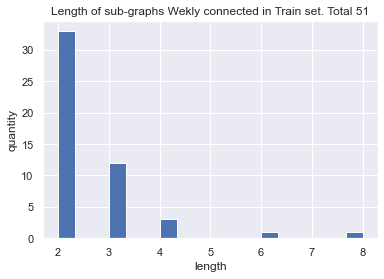

In [507]:
plt.hist(sub_graphs_weakly_train_lengths[1:], bins=18)
plt.title(f'Length of sub-graphs Wekly connected in Train set. Total {len(sub_graphs_weakly_train_lengths)}')
plt.xlabel('length')
plt.ylabel('quantity')
plt.show()

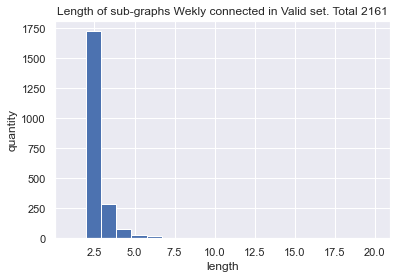

In [508]:
plt.hist(sub_graphs_weakly_valid_lengths, bins=20)
plt.title(f'Length of sub-graphs Wekly connected in Valid set. Total {len(sub_graphs_weakly_valid_lengths)}')
plt.xlabel('length')
plt.ylabel('quantity')
plt.show()

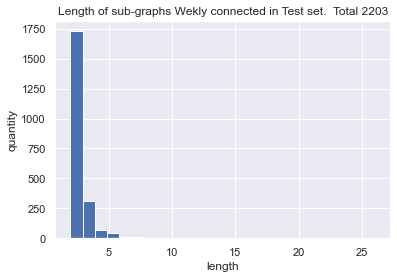

In [509]:
plt.hist(sub_graphs_weakly_test_lengths, bins=25)
plt.title(f'Length of sub-graphs Wekly connected in Test set.  Total {len(sub_graphs_weakly_test_lengths)}')
plt.xlabel('length')
plt.ylabel('quantity')
plt.show()

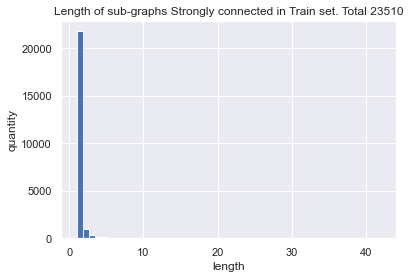

In [510]:
plt.hist(sub_graphs_strongly_train_lengths[1:], bins=50)
plt.title(f'Length of sub-graphs Strongly connected in Train set. Total {len(sub_graphs_strongly_train_lengths[1:])}')
plt.xlabel('length')
plt.ylabel('quantity')
plt.show()

In [512]:
print('There is a large subgraph os strongly-connected nodes 13806 elements.')
print(f'{sub_graphs_strongly_train_lengths[0]}')

There is a large subgraph os strongly-connected nodes 13806 elements.
13806


In [ ]:
def diameter(G, sp=None):
    return max(nx.eccentricity(G=G, sp=sp).values())

In [ ]:
# PROTOTYPE
# def diameter_parallel(G: list, processes=None):
#     """G: list of nx subgraphs"""
#     p = Pool(processes=processes)
#     orders = [sub.order() for sub in G]
#     def diameter(G, sp):
#         return max(nx.eccentricity(G=G, sp=sp))
#     list_divisor = len(p._pool) * 4 # 64 * 4
#     list_chunks = list(chunks(G, int(len(G) / node_divisor)))
#     num_chanks = len(node_chunks)
#     diameter_iter = p.starmap(
#             diameter,
#             zip([G]*num_chunks,
#             sp)
#         )
#     return diameter_iter

In [514]:
stats_path = Path(os.getcwd())/'Datasets'/'wn18rr'/'stats'
if not os.path.isdir(stats_path):
    os.mkdir(stats_path)
diam_file_paths = [
    stats_path/'diameter_weakly_train.txt',
    stats_path/'diameter_weakly_valid.txt',
    stats_path/'diameter_weakly_test.txt',
    stats_path/'diameter_strong_train.txt',
    stats_path/'diameter_strong_valid.txt',
    stats_path/'diameter_strong_test.txt',
]
# Read files if present in the directory
diam_files = [None] * 6
diameters_weakly_train, diameters_weakly_valid, diameters_weakly_test = None, None, None
diameters_strongly_train, diameters_strongly_valid, diameters_strongly_test = None, None, None
for idx, file in enumerate(diam_file_paths):
    if os.path.isfile(file):
        diam_files[idx] = [int(line) for line in read_file(file)]
diameters_weakly_train, diameters_weakly_valid, diameters_weakly_test, diameters_strongly_train, diameters_strongly_valid, diameters_strongly_test = diam_files

In [ ]:
%%time
# Diameter can only be computed on either unidirectional graph, or strongly-connected directional graph
%time diameters_weakly_train = [nx.diameter(subg.to_undirected()) for subg in sub_graphs_weakly_train]
%time diameters_weakly_valid = [nx.diameter(subg.to_undirected()) for subg in sub_graphs_weakly_valid]
%time diameters_weakly_test = [nx.diameter(subg.to_undirected()) for subg in sub_graphs_weakly_test]
%time diameters_strongly_train = [nx.diameter(subg) for subg in sub_graphs_strongly_train]
%time diameters_strongly_valid = [nx.diameter(subg) for subg in sub_graphs_strongly_valid]
%time diameters_strongly_test = [nx.diameter(subg) for subg in sub_graphs_strongly_test]

In [ ]:
force = True
diam_files = [
    stats_path/'diameter_weakly_train.txt',
    stats_path/'diameter_weakly_valid.txt',
    stats_path/'diameter_weakly_test.txt',
    stats_path/'diameter_strong_train.txt',
    stats_path/'diameter_strong_valid.txt',
    stats_path/'diameter_strong_test.txt',
]
write_file(path=diam_files[0], to_file=diameters_weakly_train, force=force)
write_file(path=diam_files[1], to_file=diameters_weakly_valid, force=force)
write_file(path=diam_files[2], to_file=diameters_weakly_test, force=force)
write_file(path=diam_files[3], to_file=diameters_strongly_train, force=force)
write_file(path=diam_files[4], to_file=diameters_strongly_valid, force=force)
write_file(path=diam_files[5], to_file=diameters_strongly_test, force=force)

In [ ]:
# Re-run with enough resources
# %time diameters_strongly_train = [nx.diameter(subg) for subg in sub_graphs_strongly_train]

In [517]:
print(f'{"Diameter Weakly Train: ":30}{max(diameters_weakly_train)}')
print(f'{"Diameter Weakly Valid: ":30}{max(diameters_weakly_valid)}')
print(f'{"Diameter Weakly Test: ":30}{max(diameters_weakly_test)}')
print()
print(f'{"Diameter Strongly Train: ":30}{max(diameters_strongly_train)}')
print(f'{"Diameter Strongly Valid: ":30}{max(diameters_strongly_valid)}')
print(f'{"Diameter Strongly Test: ":30}{max(diameters_strongly_test)}')


Diameter Weakly Train:        22
Diameter Weakly Valid:        10
Diameter Weakly Test:         6

Diameter Strongly Train:      40
Diameter Strongly Valid:      1
Diameter Strongly Test:       2


|Graph|Diameter|
|:---|:------:|
|Train Weakly|22|
|Valid Weakly|10|
|Test Weakly|6|
|---------------|------|
|Train Strongly|40|
|Valid Strongly|1|
|Test Strongly|2|


## Graph diameter is 40 when considered Strongly connected graph (directed connections are in both directions)
## Graph diameter is 22 when considered Weakly connected graph (non-directed connection in at least one direction)

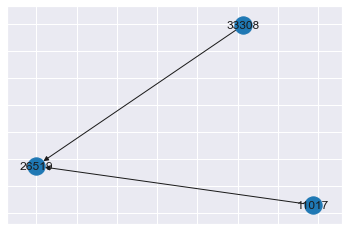

In [529]:
# Example sub-graph Weakly connected Drawn with native Matplotlib tools
nx.draw_networkx(sub_graphs_weakly_train[11])

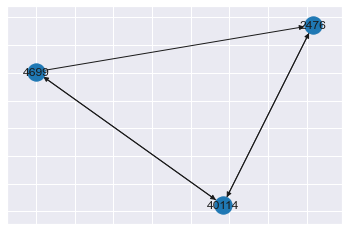

In [530]:
# Example sub-graph Strongly connected
nx.draw_networkx(sub_graphs_strongly_train[469])

Subgraph of length: 15
And diameter: 5


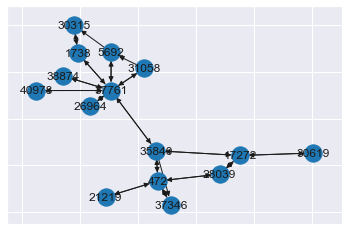

In [568]:
# Example sub-graph Strongly
# Graph of One node is considered a uni-directional or directed graph, of length 1, diameter 0
print(f'{"Subgraph of length: "}{sub_graphs_strongly_train_lengths[11]}')
print(f'{"And diameter: "}{nx.diameter(sub_graphs_strongly_train[11])}')
nx.draw_networkx(sub_graphs_strongly_train[11])

Subgraph of length: 15
And diameter: 5


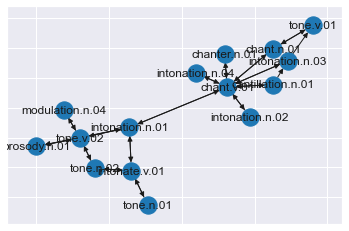

In [584]:
# Example sub-graph Strongly
# Graph of One node is considered a uni-directional or directed graph, of length 1, diameter 0
print(f'{"Subgraph of length: "}{sub_graphs_strongly_train_lengths[11]}')
print(f'{"And diameter: "}{nx.diameter(test_G)}')
nx.draw_networkx(test_G)

In [ ]:
# graph_test_uni = graph_test.to_undirected()
# sub_graphs_unidir = [graph_test_uni.subgraph(nodes) for nodes in nx.connected_components(graph_test_uni)]

In [ ]:
# NOTE Compute Clique -- complete subgraphs

## Export graph to a file to open in 3rd party software

In [ ]:
# Graph export for Gephi
ds_train_exp = [(ds.id2entity[src], ds.id2entity[dst], {'label':ds.id2relation[list(rel.keys())[0]]}) for src, dst, rel in ds_train]
graph_train_exp = DirectedGraph(ds_train_exp)
# nx.write_gexf(graph_train_exp, 'train.gexf')

In [ ]:
%%time
# Graph export to D3
ds_train_exp = [(ds.id2entity[src], ds.id2entity[dst], {'label':ds.id2relation[list(rel.keys())[0]]}) for src, dst, rel in ds_train]
graph_train_exp = DirectedGraph(ds_train_exp)
d3_data = nx.node_link_data(graph_train_exp)
import json
with open('graph_train_d3.json', 'w') as f:
    json.dump(d3_data, f)

## Plot graph

In [565]:
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="igarbuz", password="G@rbuz2208")

/Users/igorgarbuz/Dev/catlearn/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [581]:
def nicify_graph_for_drawing(G: DirectedGraph) -> DirectedGraph:
    # tmp_rep = nx.convert.to_dict_of_dicts(G)
    tmp_rep = list(G.edges(data=True))
    tmp_rep = [(ds.id2entity[src], ds.id2entity[dst], {'label':ds.id2relation[list(rel.keys())[0]]}) for src, dst, rel in tmp_rep]
    # tmp_rep = {ds.id2entity[src] : {ds.id2entity[dst]:{'label':ds.id2relation[list(lbl.keys())[0]]}} for src, dsts in G.items() for dst, lbl in dsts.items()}
    return DirectedGraph(tmp_rep)

/Users/igorgarbuz/Dev/catlearn/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [582]:
test_G = nicify_graph_for_drawing(sub_graphs_strongly_train[11])

In [598]:
# Explot and plot the ubnormally large sub-graph in strongly-connected subgraphs
print('Length:')
print(len(sub_graphs_strongly_train[0]))
sub_strong_train_13806 = nicify_graph_for_drawing(sub_graphs_strongly_train[0])

Length:
13806


In [592]:
plotter = graphistry.bind(source='src', destination='dst', node='nodeid', edge_label='label')

In [599]:
plotter.plot(sub_strong_train_13806)

## Histogram Degree of connections
Degree of 1 represents a node Without edges, degree 2 -- one edge, etc.

In [ ]:
degree_sequence_train = sorted([d for n, d in graph_train.degree()], reverse=True)

degreeCount = collections.Counter(degree_sequence_train)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')
plt.title('Train Degree Histogram')
plt.ylabel('Count')
plt.xlabel('Degree')
ax.set_xticks([d+0.4 for d in deg])
ax.set_xticklabels(deg)
plt.xlim((0, 30))
plt.show()


In [ ]:
degree_sequence_valid = sorted([d for n, d in graph_valid.degree()], reverse=True)

degreeCount = collections.Counter(degree_sequence_train)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')
plt.title('Valid Degree Histogram')
plt.ylabel('Count')
plt.xlabel('Degree')
ax.set_xticks([d+0.4 for d in deg])
ax.set_xticklabels(deg)
plt.xlim((0, 30))
plt.show()

In [ ]:
degree_sequence_test = sorted([d for n, d in graph_test.degree()], reverse=True)

degreeCount = collections.Counter(degree_sequence_train)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')
plt.title('Test Degree Histogram')
plt.ylabel('Count')
plt.xlabel('Degree')
ax.set_xticks([d+0.4 for d in deg])
ax.set_xticklabels(deg)
plt.xlim((0, 30))
plt.show()